<a href="https://colab.research.google.com/github/RgomezRo/capstone/blob/main/Time%20series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [5]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=9ec1edcc1122d704b5eec0b752c56268e4cb5e975c819abed3cb7eedad91b3cf
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [6]:
!pip install calmap

In [7]:

### importamos librerías

'''
instalar:
- plotly
- calmap
- folium
- wget
'''

#analisis
import pandas as pd 
import numpy as np
import sys
from scipy.stats import kurtosis, skew 
from scipy import stats
from google.colab import output

np.set_printoptions(threshold=sys.maxsize)
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)

#visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import calmap
import folium

#paletas
confirmados='#393e46'
fallecidos='#ff2e63'

import wget
import os
import json

# Data Loading

In [8]:

def read_FAO(fileName):
	import requests 
	file_url = "https://fenixservices.fao.org/faostat/static/bulkdownloads/"+fileName+".zip"
		
	r = requests.get(file_url, stream = True) 

	with open("temporalFile.zip", "wb") as file: 
		for block in r.iter_content(chunk_size = 1024): 
			if block: 
				file.write(block) 
		
	!unzip temporalFile.zip 

	Database = fileName + ".csv"	
	df = pd.read_csv(Database, encoding = "ISO-8859-1")

	return df




# Key differences between new and old Food Balance Sheet (FBS) methodology:

The key difference between the new and old food balances (FBS) methodologies is **the absence of a balancer variable.**

 In the past, one of the components of the FBS (often stocks, industrial
utilization or feed) would take on **the outstanding unbalanced mounts thus inheriting all the statistical errors.**

With the new methodology, the imputations for the FBS components (the data
of which are often not provided by countries) are **generated by dedicated modules; and a
balancing mechanism** will then proportionally spread the imbalances out among all the
components.

The most important output of the FBS is the Dietary Energy Supply (DES) in kilocalories per
person per day in a given country. This DES is based on the imputations generated by the
dedicated new food module. 

This module, in year t, is heavily influenced by food in year t-1,
and considering that the other variables in the module are changes in real GDP, population, and
commodity demand elasticity – all of which do not usually exhibit large variations from one
year to another - **the food quantities can be assumed to be comparable between the two methodologies.** 

However, the FBS balancing mechanism, in allocating all available quantities
to the food component for ‘food only’ commodities (e.g. meat of cattle), may result in
discrepancies with the old time series. Further analysis of this still needs to be carried out. 


In [9]:

### leer origenes

df_food_balances = read_FAO("FoodBalanceSheets_E_All_Data_(Normalized)")

df_emissions = read_FAO("Emissions_Totals_E_All_Data_(Normalized)")

df_food_transport = read_FAO("Environment_Transport_E_All_Data_(Normalized)")

df_waste_disposal = read_FAO("Emissions_Agriculture_Waste_Disposal_E_All_Data_(Normalized)")





Archive:  temporalFile.zip
  inflating: FoodBalanceSheets_E_All_Data_(Normalized).csv  
  inflating: FoodBalanceSheets_E_Flags.csv  
Archive:  temporalFile.zip
  inflating: Emissions_Totals_E_All_Data_(Normalized).csv  
  inflating: Emissions_Totals_E_Flags.csv  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  


Archive:  temporalFile.zip
  inflating: Environment_Transport_E_All_Data_(Normalized).csv  
 extracting: Environment_Transport_E_Flags.csv  
Archive:  temporalFile.zip
  inflating: Emissions_Agriculture_Waste_Disposal_E_All_Data_(Normalized).csv  
  inflating: Emissions_Agriculture_Waste_Disposal_E_Flags.csv  


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
### lectura generada por pere
df_cluster_paises = pd.read_csv("/content/drive/MyDrive/01. Data science/00. Proyecto Capstone/Cluster_Paises.csv", encoding = "ISO-8859-1")

In [13]:
def show_gaps_data(df_input):
  # create a smaller df

  df_input["MeasuredItem"]= df_input["Item"] + "-"+ df_input["Element"]

  # in order to show and fill na we aggregate a little bit the info

  df_input["area_measure_item"] = df_input["Area"] + "-"+ df_input["MeasuredItem"] 

  short_df = df_input[["Year", "Value","area_measure_item"]]


  # show  gaps in the data

  gb_df_ = short_df.pivot_table(index = ["Year"], columns = ['area_measure_item'], values = "Value", aggfunc = sum).isnull()
  #gb_df_= gb_df_.fillna(0)

  order_of_columns = list(gb_df_.sum().sort_values().index)
  
  gb_df_ = gb_df_[order_of_columns]


  plt.figure(figsize = (20, 10))
  plot = sns.heatmap(gb_df_, cbar = True, cmap = "inferno")
  plot.set_title("Null values in dataset");

  
  return df_input







In [14]:
def DataDesc(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 
    
    return summary

In [15]:
def Null_Count(df):
    df_null = df.isnull().sum().sort_values(ascending = False).rename('Null').reset_index()

    null_count = df_null['Null']
    null_percent = (null_count * 100) / (df.shape[0])

    df_null = pd.concat([df_null['index'],null_count,null_percent], axis=1, keys=['Column','Null_Count','Null_Percent'])

    return df_null[df_null['Null_Count'] != 0]





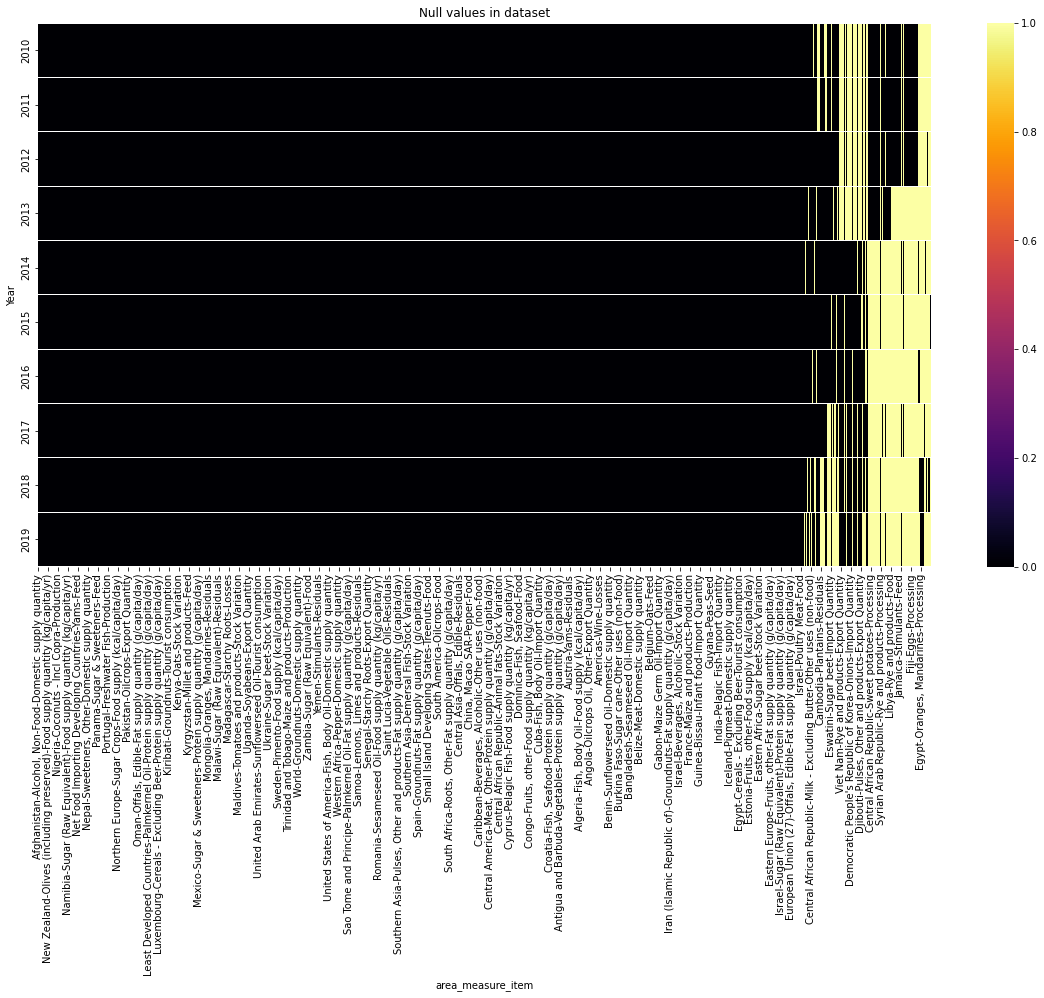

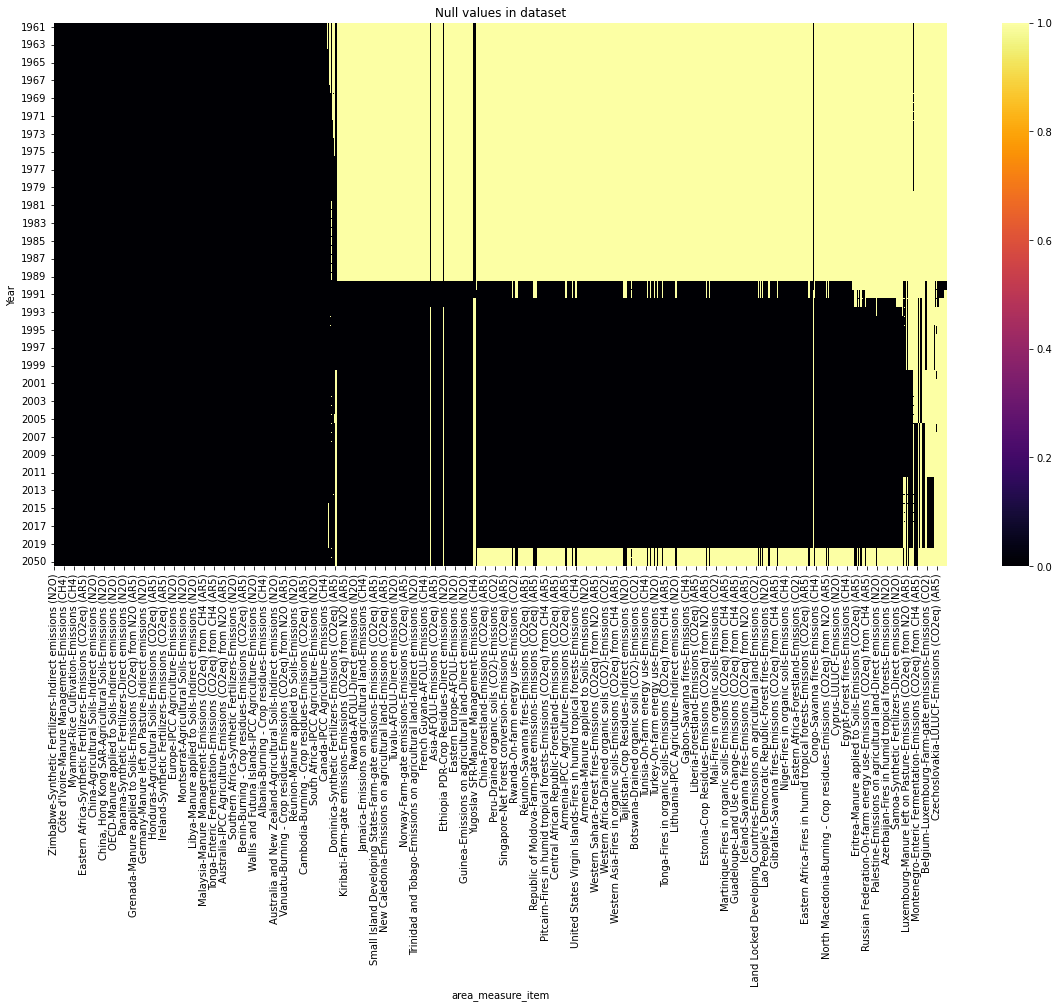

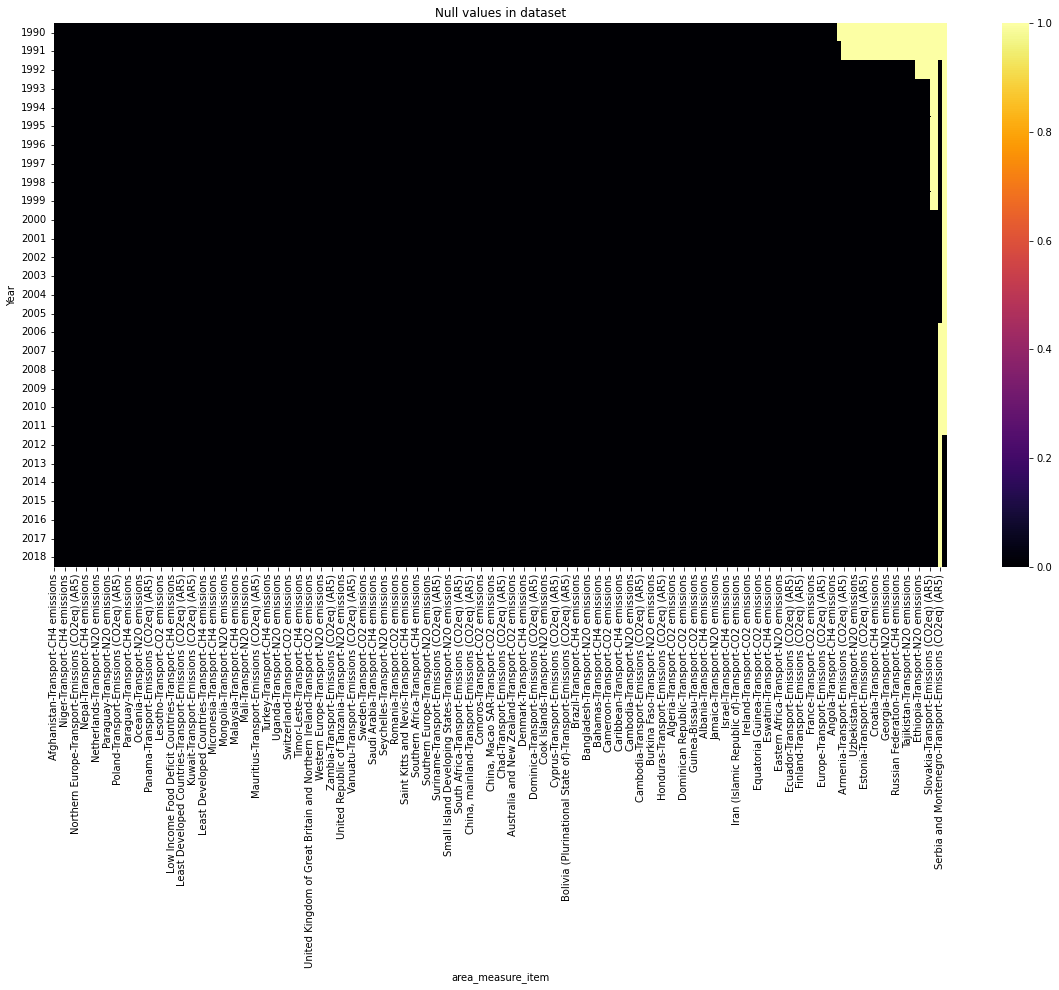

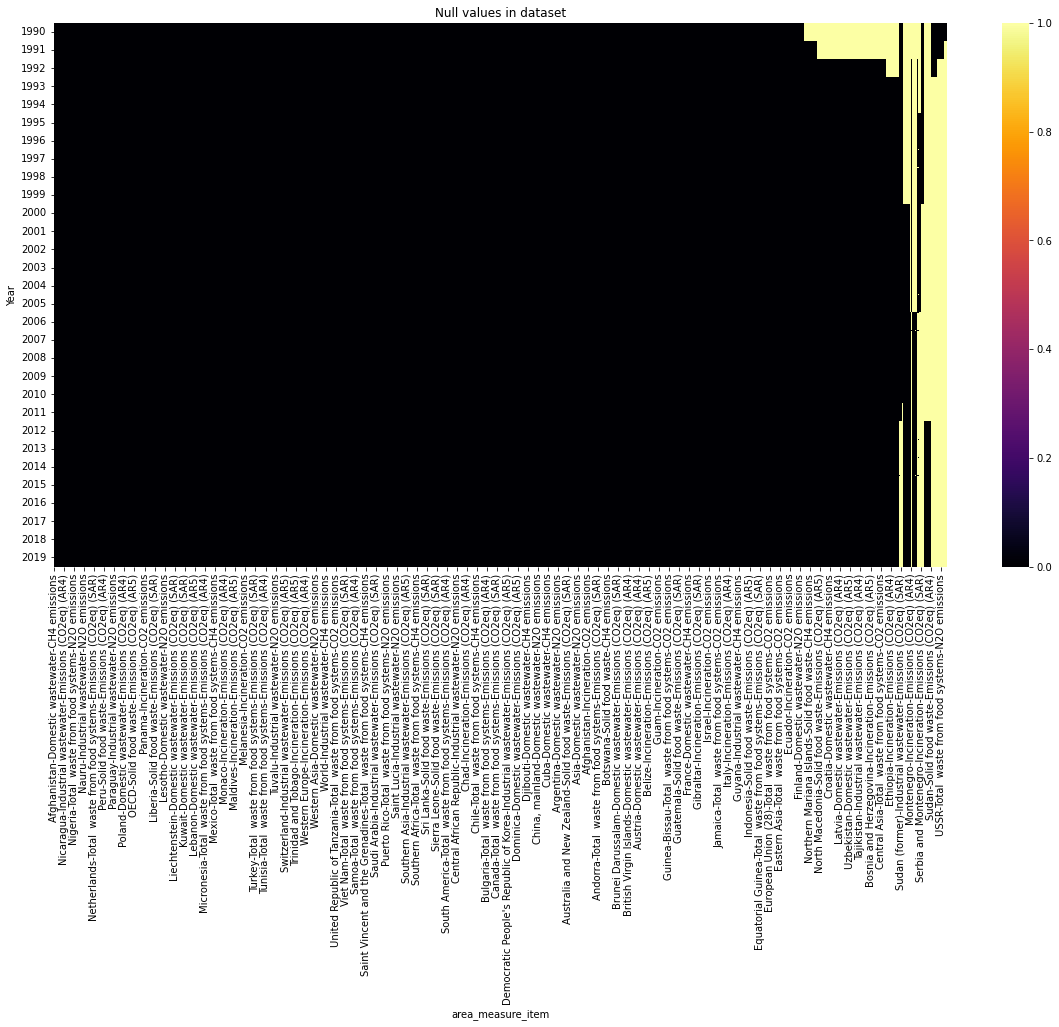

In [16]:
### mostrar donde se encuentran los gaps, tanto nulos como lineas inexistentes
df_food_balances = show_gaps_data(df_food_balances)
  
df_emissions = show_gaps_data(df_emissions)

df_food_transport = show_gaps_data(df_food_transport)

df_waste_disposal = show_gaps_data(df_waste_disposal)

In [17]:
DataDesc(df_food_balances)

### Vemos que tiene nulos y que hay que convertir a fecha el año

Dataset Shape: (2975297, 13)


Name   dtypes  Missing  Uniques  \
0           Area Code    int64        0      216   
1                Area   object        0      216   
2           Item Code    int64        0      123   
3                Item   object        0      120   
4        Element Code    int64        0       18   
5             Element   object        0       18   
6           Year Code    int64        0       10   
7                Year    int64        0       10   
8                Unit   object        0        5   
9               Value  float64    63553    68992   
10               Flag   object        0        5   
11       MeasuredItem   object        0     1910   
12  area_measure_item   object        0   311402   

                                             First Value  \
0                                                      2   
1                                            Afghanistan   
2                                                   2501   
3                                             Population   
4                                                    511   
5                          Total Population - Both sexes   
6                                                   2010   
7                                                   2010   
8                                           1000 persons   
9                                                29186.0   
10                                                     *   
11              Population-Total Population - Both sexes   
12  Afghanistan-Population-Total Population - Both sexes   

                                            Second Value  \
0                                                      2   
1                                            Afghanistan   
2                                                   2501   
3                                             Population   
4                                                    511   
5                          Total Population - Both sexes   
6                                                   2011   
7                                                   2011   
8                                           1000 persons   
9                                                30117.0   
10                                                     *   
11              Population-Total Population - Both sexes   
12  Afghanistan-Population-Total Population - Both sexes   

                                             Third Value  Entropy  
0                                                      2     7.73  
1                                            Afghanistan     7.73  
2                                                   2501     6.88  
3                                             Population     6.82  
4                                                    511     3.98  
5                          Total Population - Both sexes     3.98  
6                                                   2012     3.32  
7                                                   2012     3.32  
8                                           1000 persons     1.37  
9                                                31161.0     7.50  
10                                                     *     1.79  
11              Population-Total Population - Both sexes    10.65  
12  Afghanistan-Population-Total Population - Both sexes    18.19

In [18]:
df_food_balances.groupby(["Element","Item","Unit"]).count()

Area Code  \
Element                                Item                            Unit                         
Domestic supply quantity               Alcohol, Non-Food               1000 tonnes           2121   
                                       Alcoholic Beverages             1000 tonnes           2134   
                                       Animal fats                     1000 tonnes           2137   
                                       Apples and products             1000 tonnes           2134   
                                       Aquatic Animals, Others         1000 tonnes           1969   
                                       Aquatic Plants                  1000 tonnes           2077   
                                       Aquatic Products, Other         1000 tonnes           2077   
                                       Bananas                         1000 tonnes           2121   
                                       Barley and products             1000 tonnes           2133   
                                       Beans                           1000 tonnes           2130   
                                       Beer                            1000 tonnes           2132   
                                       Beverages, Alcoholic            1000 tonnes           2134   
                                       Beverages, Fermented            1000 tonnes           2123   
                                       Bovine Meat                     1000 tonnes           2134   
                                       Butter, Ghee                    1000 tonnes           2134   
                                       Cassava and products            1000 tonnes           2109   
                                       Cephalopods                     1000 tonnes           2113   
                                       Cereals - Excluding Beer        1000 tonnes           2134   
                                       Cereals, Other                  1000 tonnes           2134   
                                       Citrus, Other                   1000 tonnes           2127   
                                       Cloves                          1000 tonnes           2087   
                                       Cocoa Beans and products        1000 tonnes           2134   
                                       Coconut Oil                     1000 tonnes           2124   
                                       Coconuts - Incl Copra           1000 tonnes           2130   
                                       Coffee and products             1000 tonnes           2134   
                                       Cottonseed                      1000 tonnes           1912   
                                       Cottonseed Oil                  1000 tonnes           2050   
                                       Cream                           1000 tonnes           2094   
                                       Crustaceans                     1000 tonnes           2127   
                                       Dates                           1000 tonnes           2098   
                                       Demersal Fish                   1000 tonnes           2127   
                                       Eggs                            1000 tonnes           4268   
                                       Fats, Animals, Raw              1000 tonnes           2134   
                                       Fish, Body Oil                  1000 tonnes           2001   
                                       Fish, Liver Oil                 1000 tonnes           1889   
                                       Fish, Seafood                   1000 tonnes           2137   
                                       Freshwater Fish                 1000 tonnes           2137   
                                       Fruits - Excluding Wine         1000 tonnes           2134   
                                       Fruits, o

In [19]:
DataDesc(df_emissions)
### Vemos que no tiene nulos y que hay que convertir a fecha el año

Dataset Shape: (1261741, 16)


Name   dtypes  Missing  Uniques  \
0           Area Code    int64        0      280   
1                Area   object        0      280   
2           Item Code    int64        0       25   
3                Item   object        0       25   
4        Element Code    int64        0        8   
5             Element   object        0        8   
6           Year Code    int64        0       61   
7                Year    int64        0       61   
8         Source Code    int64        0        2   
9              Source   object        0        2   
10               Unit   object        0        1   
11              Value  float64        0   501072   
12               Flag   object    57525        2   
13               Note   object  1247935        2   
14       MeasuredItem   object        0      123   
15  area_measure_item   object        0    30156   

                                         First Value  \
0                                                  2   
1                                        Afghanistan   
2                                               5058   
3                               Enteric Fermentation   
4                                               7225   
5                                    Emissions (CH4)   
6                                               1961   
7                                               1961   
8                                               3050   
9                                         FAO TIER 1   
10                                        kilotonnes   
11                                          240.6831   
12                                                Fc   
13                                               NaN   
14              Enteric Fermentation-Emissions (CH4)   
15  Afghanistan-Enteric Fermentation-Emissions (CH4)   

                                        Second Value  \
0                                                  2   
1                                        Afghanistan   
2                                               5058   
3                               Enteric Fermentation   
4                                               7225   
5                                    Emissions (CH4)   
6                                               1962   
7                                               1962   
8                                               3050   
9                                         FAO TIER 1   
10                                        kilotonnes   
11                                          245.3106   
12                                                Fc   
13                                               NaN   
14              Enteric Fermentation-Emissions (CH4)   
15  Afghanistan-Enteric Fermentation-Emissions (CH4)   

                                         Third Value  Entropy  
0                                                  2     8.04  
1                                        Afghanistan     8.04  
2                                               5058     4.43  
3                               Enteric Fermentation     4.43  
4                                               7225     2.91  
5                                    Emissions (CH4)     2.91  
6                                               1963     5.73  
7                                               1963     5.73  
8                                               3050     0.36  
9                                         FAO TIER 1     0.36  
10                                        kilotonnes     0.00  
11                                          255.8285    16.18  
12                                                Fc     0.01  
13                                               NaN     0.82  
14              Enteric Fermentation-Emissions (CH4)     6.82  
15  Afghanistan-Enteric Fermentation-Emissions (CH4)    14.74

In [20]:
df_emissions.groupby(["Element","Item","Unit"]).count()

Area Code  \
Element                          Item                            Unit                    
Direct emissions (N2O)           AFOLU                           kilotonnes       7710   
                                 Agricultural Soils              kilotonnes      15506   
                                 Crop Residues                   kilotonnes      14366   
                                 Emissions on agricultural land  kilotonnes       7710   
                                 Farm-gate emissions             kilotonnes       7710   
                                 IPCC Agriculture                kilotonnes      14054   
                                 Manure applied to Soils         kilotonnes      14997   
                                 Manure left on Pasture          kilotonnes      14992   
                                 Synthetic Fertilizers           kilotonnes      12391   
Emissions (CH4)                  AFOLU                           kilotonnes       8401   
                                 Agricultural Soils              kilotonnes          9   
                                 Burning - Crop residues         kilotonnes      14271   
                                 Emissions on agricultural land  kilotonnes       8445   
                                 Enteric Fermentation            kilotonnes      15691   
                                 Farm-gate emissions             kilotonnes       8445   
                                 Fires in humid tropical forests kilotonnes       7915   
                                 Fires in organic soils          kilotonnes       7915   
                                 Forest fires                    kilotonnes       8144   
                                 IPCC Agriculture                kilotonnes      16928   
                                 LULUCF                          kilotonnes       9495   
                                 Land Use change                 kilotonnes       7915   
                                 Manure Management               kilotonnes      15691   
                                 On-farm energy use              kilotonnes       7568   
                                 Rice Cultivation                kilotonnes       9844   
                                 Savanna fires                   kilotonnes       8619   
Emissions (CO2)                  AFOLU                           kilotonnes       8035   
                                 Drained organic soils (CO2)     kilotonnes       4384   
                                 Emissions on agricultural land  kilotonnes       8049   
                                 Farm-gate emissions             kilotonnes       7623   
                                 Fires in organic soils          kilotonnes       7932   
                                 Forest fires                    kilotonnes         90   
                                 Forestland                      kilotonnes       8957   
                                 LULUCF                          kilotonnes      10043   
                                 Land Use change                 kilotonnes       8035   
                                 Net Forest conversion           kilotonnes       8872   
                                 On-farm energy use              kilotonnes       7568   
                                 Savanna fires                   kilotonnes        209   
Emissions (CO2eq) (AR5)          AFOLU                           kilotonnes       8525   
                                 Agricultural Soils              kilotonnes      16044   
                                 Burning - Crop residues         kilotonnes      14277   
                                 Crop Residues                   kilotonnes      14366   
                                 Drained organic soils           kilotonnes       5178   
                                 Drained organic soils (CO2)     kilotonnes       4384   
                           

In [21]:
DataDesc(df_food_transport)

### Vemos que no tiene nulos y que hay que convertir a fecha el año

Dataset Shape: (26248, 13)


Name   dtypes  Missing  Uniques  \
0           Area Code    int64        0      230   
1                Area   object        0      230   
2           Item Code    int64        0        1   
3                Item   object        0        1   
4        Element Code    int64        0        4   
5             Element   object        0        4   
6           Year Code    int64        0       29   
7                Year    int64        0       29   
8                Unit   object        0        1   
9               Value  float64        0    23842   
10               Flag   object        0        2   
11       MeasuredItem   object        0        4   
12  area_measure_item   object        0      920   

                                      First Value  \
0                                               2   
1                                     Afghanistan   
2                                            6815   
3                                       Transport   
4                                          723113   
5                         Emissions (CO2eq) (AR5)   
6                                            1990   
7                                            1990   
8                                      kilotonnes   
9                                       46.514576   
10                                             Fc   
11              Transport-Emissions (CO2eq) (AR5)   
12  Afghanistan-Transport-Emissions (CO2eq) (AR5)   

                                     Second Value  \
0                                               2   
1                                     Afghanistan   
2                                            6815   
3                                       Transport   
4                                          723113   
5                         Emissions (CO2eq) (AR5)   
6                                            1991   
7                                            1991   
8                                      kilotonnes   
9                                       45.110752   
10                                             Fc   
11              Transport-Emissions (CO2eq) (AR5)   
12  Afghanistan-Transport-Emissions (CO2eq) (AR5)   

                                      Third Value  Entropy  
0                                               2     7.84  
1                                     Afghanistan     7.84  
2                                            6815     0.00  
3                                       Transport     0.00  
4                                          723113     2.00  
5                         Emissions (CO2eq) (AR5)     2.00  
6                                            1992     4.86  
7                                            1992     4.86  
8                                      kilotonnes     0.00  
9                                       26.788148    14.46  
10                                             Fc     0.65  
11              Transport-Emissions (CO2eq) (AR5)     2.00  
12  Afghanistan-Transport-Emissions (CO2eq) (AR5)     9.84

In [22]:
df_food_transport.groupby(["Element","Item","Unit"]).count()

Area Code  Area  Item Code  \
Element                 Item      Unit                                     
CH4 emissions           Transport kilotonnes       6562  6562       6562   
CO2 emissions           Transport kilotonnes       6562  6562       6562   
Emissions (CO2eq) (AR5) Transport kilotonnes       6562  6562       6562   
N2O emissions           Transport kilotonnes       6562  6562       6562   

                                              Element Code  Year Code  Year  \
Element                 Item      Unit                                        
CH4 emissions           Transport kilotonnes          6562       6562  6562   
CO2 emissions           Transport kilotonnes          6562       6562  6562   
Emissions (CO2eq) (AR5) Transport kilotonnes          6562       6562  6562   
N2O emissions           Transport kilotonnes          6562       6562  6562   

                                              Value  Flag  MeasuredItem  \
Element                 Item      Unit                                    
CH4 emissions           Transport kilotonnes   6562  6562          6562   
CO2 emissions           Transport kilotonnes   6562  6562          6562   
Emissions (CO2eq) (AR5) Transport kilotonnes   6562  6562          6562   
N2O emissions           Transport kilotonnes   6562  6562          6562   

                                              area_measure_item  
Element                 Item      Unit                           
CH4 emissions           Transport kilotonnes               6562  
CO2 emissions           Transport kilotonnes               6562  
Emissions (CO2eq) (AR5) Transport kilotonnes               6562  
N2O emissions           Transport kilotonnes               6562

In [23]:
DataDesc(df_waste_disposal)

### Vemos que no tiene nulos y que hay que convertir a fecha el año

Dataset Shape: (178270, 13)


Name   dtypes  Missing  Uniques  \
0           Area Code    int64        0      271   
1                Area   object        0      271   
2           Item Code    int64        0        5   
3                Item   object        0        5   
4        Element Code    int64        0        6   
5             Element   object        0        6   
6           Year Code    int64        0       30   
7                Year    int64        0       30   
8                Unit   object        0        1   
9               Value  float64        0   130554   
10               Flag   object        0        2   
11       MeasuredItem   object        0       24   
12  area_measure_item   object        0     6198   

                                                First Value  \
0                                                         2   
1                                               Afghanistan   
2                                                      6988   
3                                       Domestic wastewater   
4                                                    723112   
5                                   Emissions (CO2eq) (SAR)   
6                                                      1990   
7                                                      1990   
8                                                 gigagrams   
9                                                419.901499   
10                                                       Fc   
11              Domestic wastewater-Emissions (CO2eq) (SAR)   
12  Afghanistan-Domestic wastewater-Emissions (CO2eq) (SAR)   

                                               Second Value  \
0                                                         2   
1                                               Afghanistan   
2                                                      6988   
3                                       Domestic wastewater   
4                                                    723112   
5                                   Emissions (CO2eq) (SAR)   
6                                                      1991   
7                                                      1991   
8                                                 gigagrams   
9                                                440.671818   
10                                                       Fc   
11              Domestic wastewater-Emissions (CO2eq) (SAR)   
12  Afghanistan-Domestic wastewater-Emissions (CO2eq) (SAR)   

                                                Third Value  Entropy  
0                                                         2     8.02  
1                                               Afghanistan     8.02  
2                                                      6988     2.30  
3                                       Domestic wastewater     2.30  
4                                                    723112     2.52  
5                                   Emissions (CO2eq) (SAR)     2.52  
6                                                      1992     4.91  
7                                                      1992     4.91  
8                                                 gigagrams     0.00  
9                                                472.420303    14.92  
10                                                       Fc     0.95  
11              Domestic wastewater-Emissions (CO2eq) (SAR)     4.58  
12  Afghanistan-Domestic wastewater-Emissions (CO2eq) (SAR)    12.57

In [24]:
df_waste_disposal.groupby(["Element","Item","Unit"]).count()

Area Code  \
Element                 Item                           Unit                   
CH4 emissions           Domestic wastewater            gigagrams       7375   
                        Industrial wastewater          gigagrams       7515   
                        Solid food waste               gigagrams       7371   
                        Total  waste from food systems gigagrams       7786   
CO2 emissions           Incineration                   gigagrams       7346   
                        Total  waste from food systems gigagrams       7346   
Emissions (CO2eq) (AR4) Domestic wastewater            gigagrams       7375   
                        Incineration                   gigagrams       7346   
                        Industrial wastewater          gigagrams       7515   
                        Solid food waste               gigagrams       7371   
                        Total  waste from food systems gigagrams       7345   
Emissions (CO2eq) (AR5) Domestic wastewater            gigagrams       7375   
                        Incineration                   gigagrams       7346   
                        Industrial wastewater          gigagrams       7515   
                        Solid food waste               gigagrams       7371   
                        Total  waste from food systems gigagrams       7345   
Emissions (CO2eq) (SAR) Domestic wastewater            gigagrams       7375   
                        Incineration                   gigagrams       7346   
                        Industrial wastewater          gigagrams       7515   
                        Solid food waste               gigagrams       7371   
                        Total  waste from food systems gigagrams       7345   
N2O emissions           Domestic wastewater            gigagrams       7374   
                        Industrial wastewater          gigagrams       7515   
                        Total  waste from food systems gigagrams       7786   

                                                                  Area  \
Element                 Item                           Unit              
CH4 emissions           Domestic wastewater            gigagrams  7375   
                        Industrial wastewater          gigagrams  7515   
                        Solid food waste               gigagrams  7371   
                        Total  waste from food systems gigagrams  7786   
CO2 emissions           Incineration                   gigagrams  7346   
                        Total  waste from food systems gigagrams  7346   
Emissions (CO2eq) (AR4) Domestic wastewater            gigagrams  7375   
                        Incineration                   gigagrams  7346   
                        Industrial wastewater          gigagrams  7515   
                        Solid food waste               gigagrams  7371   
                        Total  waste from food systems gigagrams  7345   
Emissions (CO2eq) (AR5) Domestic wastewater            gigagrams  7375   
                        Incineration                   gigagrams  7346   
                        Industrial wastewater          gigagrams  7515   
                        Solid food waste               gigagrams  7371   
                        Total  waste from food systems gigagrams  7345   
Emissions (CO2eq) (SAR) Domestic wastewater            gigagrams  7375   
                        Incineration                   gigagrams  7346   
                        Industrial wastewater          gigagrams  7515   
                        Solid food waste               gigagrams  7371   
                        Total  waste from food systems gigagrams  7345   
N2O emissions           Domestic wastewater            gigagrams  7374   
                        Industrial wastewater          gigagrams  7515   
                        Total  waste from food systems gigagrams  7786   

                                                                  Item Code  \
Element

In [25]:
DataDesc(df_cluster_paises)
### Vemos que el cluster tiene 3 divisiones

Dataset Shape: (205, 3)


Name  dtypes  Missing  Uniques  First Value Second Value Third Value  \
0  Unnamed: 0   int64        0      205            0            1           2   
1        Area  object        0      205  Afghanistan      Albania     Algeria   
2     cluster   int64        0        3            1            1           1   

   Entropy  
0     7.68  
1     7.68  
2     1.31

In [26]:
df_cluster_paises.head(6)

# ejemplo de dos de ellas

Unnamed: 0                 Area  cluster
0           0          Afghanistan        1
1           1              Albania        1
2           2              Algeria        1
3           4               Angola        1
4           5             Anguilla        0
5           6  Antigua and Barbuda        0

In [27]:
def my_interp(x):
    if x.notnull().sum() > 1:
      return x.interpolate(method='nearest').ffill().bfill()
    else:
      if(x.isna().all()):
        return x.fillna(0)
      else:
        return x.ffill().bfill()

In [28]:
def generate_columns_for_dataset(old_df, columns_to_transpose,columns_to_transpose_by,column_with_value,pathToGenerateConfigFile):
  filtering_list = []
  df_filtered = old_df
  continue_with_old_config = "N"
  df_to_return = pd.DataFrame() 
  

  if(os.path.isfile(pathToGenerateConfigFile)):
    continue_with_old_config = input("\r\nYa existe un archivo con este nombre y esta ruta, pulse [Y] si desea recuperarlo:\r\n "   )
  
  

  if(continue_with_old_config=="Y"):
    with open(pathToGenerateConfigFile, "r") as read_file:
   
      df_to_return = pd.read_csv(pathToGenerateConfigFile, encoding = "ISO-8859-1")


  else:  
    for column_index in range(len(columns_to_transpose)): 

      current_column = columns_to_transpose[column_index]
      array_of_measured_items =  df_filtered.groupby(current_column).count().add_suffix("_count").reset_index()[current_column]
      
      output.clear()
      if(column_index != (len(columns_to_transpose)-1)):
        
        display(array_of_measured_items)
        value_to_filter = int(input("\r\nIntroduzca el índice de un [" + current_column + "] para filtrar:\r\n "   ))
        filtering_list.append(array_of_measured_items[value_to_filter])

      else:

        # this is the last type of row to transpose.
        decision = int(input(" \r\n Introduzca [1] si desea incluir todos los valores de ["+current_column + "]. \r\n Si prefiere filtrar los valores pulse [2]: \r\n" ))
        
        if(decision == 2):

          display(array_of_measured_items)
          value_to_filter = int(input("\r\nIntroduzca el índice de un [" + current_column + "] para filtrar:\r\n "   ))
          filtering_list.append(array_of_measured_items[value_to_filter])

          
      display(filtering_list)

      if(len(filtering_list)>0):

        for row_index in range(len(filtering_list)):

          row_to_filter = filtering_list[row_index]
          
          col = columns_to_transpose[row_index]
          df_filtered = df_filtered[df_filtered[col]==row_to_filter]
 
    columns_to_generate_prefix = "" 

    if(len(filtering_list)>0):
        for row_index in range(len(filtering_list)):
          row_to_filter = filtering_list[row_index]
          # we only filter if it is NOT the last column (this way we will be able to traspose it correctly)
          #><
          if(row_index < (len(columns_to_transpose)-1)):
            col = columns_to_transpose[row_index]
            df_filtered = df_filtered[df_filtered[col]==row_to_filter]
            columns_to_generate_prefix = (columns_to_generate_prefix + " " + row_to_filter).strip()

    
    last_granularity = columns_to_transpose[-1]
    columns_to_group_by = []
    columns_to_group_by.extend(columns_to_transpose_by)
    columns_to_group_by.append(last_granularity)

    gb_df= df_filtered.groupby(columns_to_group_by).sum().reset_index()
    df_to_return = df_filtered.groupby(columns_to_transpose_by).sum().reset_index()[columns_to_transpose_by]
    
    
    for last_level in gb_df[last_granularity].unique():
      
      column_name = columns_to_generate_prefix+ " " +last_level
      output.clear()
      display("Generating column "+ column_name)
      partial_df_to_merge = gb_df[gb_df[last_granularity]==last_level].copy()

      

      partial_df_to_merge[column_name] = partial_df_to_merge[column_with_value]

       #### INTERPOLATION FOR NULLS CALCULATION BASED ON AGRUPATIONS ALREADY DONE
      partial_df_to_merge[column_name] = partial_df_to_merge.groupby(columns_to_group_by)[column_name].apply(lambda x:my_interp(x))
      
      
      partial_df_to_merge.reset_index()



      list_column_to_use = []
      list_column_to_use.append(column_name)
      list_column_to_use.extend(columns_to_transpose_by) 
      
      partial_df_to_merge_cleaned = partial_df_to_merge[list_column_to_use].copy()
      df_to_return = pd.merge(df_to_return, partial_df_to_merge_cleaned, on = columns_to_transpose_by, how = "left")
  output.clear()
  
  if(continue_with_old_config!="Y"):
    df_to_return.to_csv(pathToGenerateConfigFile,index=False)
  
  display(df_to_return.head(3).T.head(10))    
  
  return df_to_return
    
  
  

    
        
      
    





In [29]:
path ="/content/drive/MyDrive/01. Data science/00. Proyecto Capstone/transposicion_food.csv"

### if you dont have the file the order of input is 
###    -   n for the question 
###    -   6 for selection of Element
###    -   All items for selection of Items   

feature_foods = generate_columns_for_dataset(df_food_balances,["Element","Item"],["Area","Year"],"Value",path)


0  \
Area                                                      Afghanistan   
Year                                                             2010   
Food supply quantity (kg/capita/yr) Alcoholic Beverages          0.11   
Food supply quantity (kg/capita/yr) Animal fats                  1.41   
Food supply quantity (kg/capita/yr) Apples and products          2.83   
Food supply quantity (kg/capita/yr) Bananas                      0.73   
Food supply quantity (kg/capita/yr) Barley and products          1.09   
Food supply quantity (kg/capita/yr) Beer                          0.1   
Food supply quantity (kg/capita/yr) Beverages, Alcoholic          0.0   
Food supply quantity (kg/capita/yr) Bovine Meat                  4.58   

                                                                    1  \
Area                                                      Afghanistan   
Year                                                             2011   
Food supply quantity (kg/capita/yr) Alcoholic Beverages           0.1   
Food supply quantity (kg/capita/yr) Animal fats                  1.41   
Food supply quantity (kg/capita/yr) Apples and products          2.63   
Food supply quantity (kg/capita/yr) Bananas                      0.92   
Food supply quantity (kg/capita/yr) Barley and products          1.85   
Food supply quantity (kg/capita/yr) Beer                         0.09   
Food supply quantity (kg/capita/yr) Beverages, Alcoholic          0.0   
Food supply quantity (kg/capita/yr) Bovine Meat                  4.66   

                                                                    2  
Area                                                      Afghanistan  
Year                                                             2012  
Food supply quantity (kg/capita/yr) Alcoholic Beverages          0.09  
Food supply quantity (kg/capita/yr) Animal fats                  1.43  
Food supply quantity (kg/capita/yr) Apples and products          2.62  
Food supply quantity (kg/capita/yr) Bananas                      1.53  
Food supply quantity (kg/capita/yr) Barley and products           1.3  
Food supply quantity (kg/capita/yr) Beer                         0.09  
Food supply quantity (kg/capita/yr) Beverages, Alcoholic          0.0  
Food supply quantity (kg/capita/yr) Bovine Meat                   4.3

In [30]:
### antes veíamos que food balances contenía nulos 

Null_Count(df_food_balances)

Column  Null_Count  Null_Percent
0  Value       63553      2.136022

In [31]:
### veamos cuantos nulos contiene nuestro nuevo generado dataset,estos nulos corresponden a años para los que no aparece información
Null_Count(feature_foods).head(10)

Column  Null_Count  \
0      Food supply quantity (kg/capita/yr) Alcohol, Non-Food        2092   
1           Food supply quantity (kg/capita/yr) Palm kernels        2072   
2  Food supply quantity (kg/capita/yr) Meat, Aquatic Mammals        2054   
3             Food supply quantity (kg/capita/yr) Cottonseed        2009   
4             Food supply quantity (kg/capita/yr) Sugar beet        1664   
5  Food supply quantity (kg/capita/yr) Sugar non-centrifugal        1626   
6           Food supply quantity (kg/capita/yr) Ricebran Oil        1410   
7   Food supply quantity (kg/capita/yr) Sorghum and products        1126   
8    Food supply quantity (kg/capita/yr) Millet and products        1106   
9             Food supply quantity (kg/capita/yr) Sugar cane        1016   

   Null_Percent  
0     98.031865  
1     97.094658  
2     96.251172  
3     94.142455  
4     77.975633  
5     76.194939  
6     66.073102  
7     52.764761  
8     51.827554  
9     47.610122

In [32]:
#### INTERPOLATION FOR NULLS CALCULATION BASED ON AGRUPATIONS ALREADY DONE
for column in feature_foods.columns[2:]:
  output.clear()
  display("Generating column "+column)
  feature_foods[column] = feature_foods.groupby("Area")[column].apply(lambda x:my_interp(x))
      

'Generating column Food supply quantity (kg/capita/yr) Meat, Aquatic Mammals'

In [33]:
### veamos cuantos nulos contiene nuestro nuevo generado dataset
Null_Count(feature_foods).head(10)

Empty DataFrame
Columns: [Column, Null_Count, Null_Percent]
Index: []

In [34]:
df_Test = feature_foods[feature_foods["Area"]=="Sudan"].reset_index()
display(df_Test["Food supply quantity (kg/capita/yr) Alcohol, Non-Food"].interpolate(method='nearest'))

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
Name: Food supply quantity (kg/capita/yr) Alcohol, Non-Food, dtype: float64

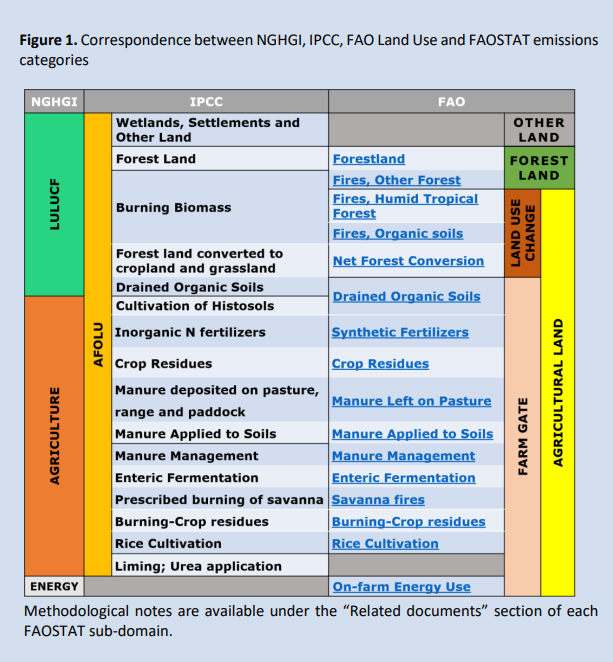



https://fenixservices.fao.org/faostat/static/documents/GT/GT_e.pdf

https://fenixservices.fao.org/faostat/static/documents/GT/Mapping_to_UNFCCC_IPCC.pdf



Los grupos que se observan en la imagen se encuentran tb en el dataset, tenemos que borrarlos.
Por otro lado existe un descuadre de 2 categorías de la imagen que corresponden a 4 items del dataset (Drained Organic Soils x2 y Forest Fires other = savanna fires + forest fires )

In [35]:
df_emissions.groupby(["Item","Item Code","Unit"]).sum().sort_values(by="Item Code")

Area Code  Element Code  \
Item                            Item Code Unit                                  
LULUCF                          1707      kilotonnes   42977218   18939775973   
Agricultural Soils              1709      kilotonnes   71379257   23569059446   
IPCC Agriculture                1711      kilotonnes   99205521   37203688653   
Enteric Fermentation            5058      kilotonnes   42740013   22809127629   
Manure Management               5059      kilotonnes   71200365   34227525846   
Rice Cultivation                5060      kilotonnes   38469234   14320568844   
Synthetic Fertilizers           5061      kilotonnes   66622426   18194077598   
Manure applied to Soils         5062      kilotonnes   70099791   22023256722   
Manure left on Pasture          5063      kilotonnes   70146199   22015947272   
Crop Residues                   5064      kilotonnes   69564499   21096028372   
Burning - Crop residues         5066      kilotonnes   70125151   31155195428   
Land Use change                 6516      kilotonnes   41372364   17449729125   
Drained organic soils           6729      kilotonnes    6171197    3744279114   
Net Forest conversion           6750      kilotonnes   14969318    6479984592   
Forestland                      6751      kilotonnes   14999296    6542067402   
Savanna fires                   6795      kilotonnes   37671752   18827790541   
AFOLU                           6824      kilotonnes   58110750   18629650333   
Forest fires                    6992      kilotonnes   37273321   17739946193   
Fires in organic soils          6993      kilotonnes   27562970   11584336522   
On-farm energy use              6994      kilotonnes   40976658   16600915056   
Emissions on agricultural land  6995      kilotonnes   58147506   18704255701   
Farm-gate emissions             6996      kilotonnes   58063320   18636077233   
Drained organic soils (N2O)     67291     kilotonnes   19397115    7587485696   
Drained organic soils (CO2)     67292     kilotonnes   12620474    3202012224   
Fires in humid tropical forests 69921     kilotonnes   34449420   17304517010   

                                                      Year Code       Year  \
Item                            Item Code Unit                               
LULUCF                          1707      kilotonnes  110223362  110223362   
Agricultural Soils              1709      kilotonnes  157722349  157722349   
IPCC Agriculture                1711      kilotonnes  224834003  224834003   
Enteric Fermentation            5058      kilotonnes   93814539   93814539   
Manure Management               5059      kilotonnes  156001733  156001733   
Rice Cultivation                5060      kilotonnes   58855167   58855167   
Synthetic Fertilizers           5061      kilotonnes  120848626  120848626   
Manure applied to Soils         5062      kilotonnes  146932497  146932497   
Manure left on Pasture          5063      kilotonnes  146891933  146891933   
Crop Residues                   5064      kilotonnes  140592171  140592171   
Burning - Crop residues         5066      kilotonnes  141977386  141977386   
Land Use change                 6516      kilotonnes   95680524   95680524   
Drained organic soils           6729      kilotonnes   10380105   10380105   
Net Forest conversion           6750      kilotonnes   35571192   35571192   
Forestland                      6751      kilotonnes   35911684   35911684   
Savanna fires                   6795      kilotonnes   86754788   86754788   
AFOLU                           6824      kilotonnes  131608030  131608030   
Forest fires                    6992      kilotonnes   81623455   81623455   
Fires in organic soils          6993      kilotonnes   63534568   63534568   
On-farm energy use              6994      kilotonnes   91029258   91029258   
Emissions on agricultural land  6995      kilotonnes  132017620  132017620   
Farm-gate emissions             6996      kilotonnes  130983471  1309834

In [36]:
array_aggregations = []
array_aggregations.append("LULUCF")
array_aggregations.append("Agricultural Soils")
array_aggregations.append("IPCC Agriculture")
array_aggregations.append("Land Use change")
array_aggregations.append("AFOLU")
array_aggregations.append("Emissions on agricultural land")
array_aggregations.append("Farm-gate emissions")

df_emissions= df_emissions.drop(df_emissions[df_emissions["Element"].isin(array_aggregations)].index)

In [37]:
df_emissions.groupby(["Item","Item Code","Unit"]).count().sort_values(by="Item Code")

Area Code    Area  \
Item                            Item Code Unit                            
LULUCF                          1707      kilotonnes      54988   54988   
Agricultural Soils              1709      kilotonnes      79107   79107   
IPCC Agriculture                1711      kilotonnes     112762  112762   
Enteric Fermentation            5058      kilotonnes      47049   47049   
Manure Management               5059      kilotonnes      78238   78238   
Rice Cultivation                5060      kilotonnes      29532   29532   
Synthetic Fertilizers           5061      kilotonnes      60592   60592   
Manure applied to Soils         5062      kilotonnes      73710   73710   
Manure left on Pasture          5063      kilotonnes      73690   73690   
Crop Residues                   5064      kilotonnes      70526   70526   
Burning - Crop residues         5066      kilotonnes      71225   71225   
Land Use change                 6516      kilotonnes      47730   47730   
Drained organic soils           6729      kilotonnes       5178    5178   
Net Forest conversion           6750      kilotonnes      17744   17744   
Forestland                      6751      kilotonnes      17914   17914   
Savanna fires                   6795      kilotonnes      43277   43277   
AFOLU                           6824      kilotonnes      65592   65592   
Forest fires                    6992      kilotonnes      40718   40718   
Fires in organic soils          6993      kilotonnes      31694   31694   
On-farm energy use              6994      kilotonnes      45408   45408   
Emissions on agricultural land  6995      kilotonnes      65796   65796   
Farm-gate emissions             6996      kilotonnes      65280   65280   
Drained organic soils (N2O)     67291     kilotonnes      15648   15648   
Drained organic soils (CO2)     67292     kilotonnes       8768    8768   
Fires in humid tropical forests 69921     kilotonnes      39575   39575   

                                                      Element Code  Element  \
Item                            Item Code Unit                                
LULUCF                          1707      kilotonnes         54988    54988   
Agricultural Soils              1709      kilotonnes         79107    79107   
IPCC Agriculture                1711      kilotonnes        112762   112762   
Enteric Fermentation            5058      kilotonnes         47049    47049   
Manure Management               5059      kilotonnes         78238    78238   
Rice Cultivation                5060      kilotonnes         29532    29532   
Synthetic Fertilizers           5061      kilotonnes         60592    60592   
Manure applied to Soils         5062      kilotonnes         73710    73710   
Manure left on Pasture          5063      kilotonnes         73690    73690   
Crop Residues                   5064      kilotonnes         70526    70526   
Burning - Crop residues         5066      kilotonnes         71225    71225   
Land Use change                 6516      kilotonnes         47730    47730   
Drained organic soils           6729      kilotonnes          5178     5178   
Net Forest conversion           6750      kilotonnes         17744    17744   
Forestland                      6751      kilotonnes         17914    17914   
Savanna fires                   6795      kilotonnes         43277    43277   
AFOLU                           6824      kilotonnes         65592    65592   
Forest fires                    6992      kilotonnes         40718    40718   
Fires in organic soils          6993      kilotonnes         31694    31694   
On-farm energy use              6994      kilotonnes         45408    45408   
Emissions on agricultural land  6995      kilotonnes         65796    65796   
Farm-gate emissions             6996      kilotonnes         65280    65280   
Drained organic soils (N2O)     67291     kilotonnes         15648    15648   
Drained organic soils (CO2)     67292     kilotonnes 

In [38]:
# Una vez sacadas las agrupaciones podemos sumar la huella de carbono de cada pais y año
# sacando todos los datos de dióxido de carbono equivalente

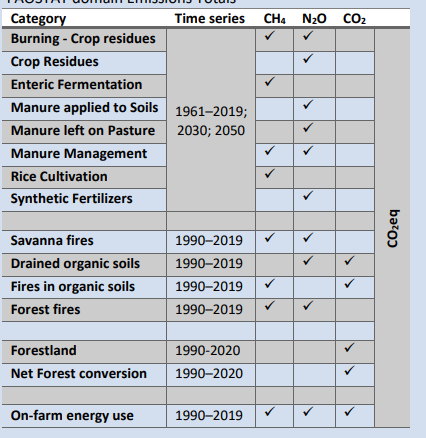

In [39]:
### Como vemos hay datos completos desde 1990. Al tener incompletos los años de 

In [40]:
path ="/content/drive/MyDrive/01. Data science/00. Proyecto Capstone/transposicion_emisiones_CO2_eq.csv"

### Si no tienes el archivo el orden de imputación es: 
###    -   n for the question
###    -   [2] All items for selection of [Element]
###    -   [3] Para la selección de las emisiones (CO2eq) 

feature_emissions_CO2_eq = generate_columns_for_dataset(df_emissions,["Element"],["Area","Year"],"Value",path)


0            1            2
Area                      Afghanistan  Afghanistan  Afghanistan
Year                             1961         1962         1963
 Emissions (CO2eq) (AR5)   24215.6035   24417.6631   25181.3706

In [41]:
feature_emissions_CO2_eq.head(4 )

Area  Year   Emissions (CO2eq) (AR5)
0  Afghanistan  1961                24215.6035
1  Afghanistan  1962                24417.6631
2  Afghanistan  1963                25181.3706
3  Afghanistan  1964                25628.0687

In [42]:
feature_emissions_CO2_eq.head(10)

Area  Year   Emissions (CO2eq) (AR5)
0  Afghanistan  1961                24215.6035
1  Afghanistan  1962                24417.6631
2  Afghanistan  1963                25181.3706
3  Afghanistan  1964                25628.0687
4  Afghanistan  1965                26219.4802
5  Afghanistan  1966                27125.8129
6  Afghanistan  1967                27410.6202
7  Afghanistan  1968                28319.0168
8  Afghanistan  1969                28136.2565
9  Afghanistan  1970                28383.2813

In [43]:
### Mezclamos los dos datasets cogiendo de base el de food balances
full_df = pd.merge(feature_foods, feature_emissions_CO2_eq, on = ["Area","Year"], how = "left")


In [44]:
Null_Count(full_df)

Empty DataFrame
Columns: [Column, Null_Count, Null_Percent]
Index: []

# DATA UNDERSTANDING

## Análisis de los datos

### Tamaño del dataset

In [ ]:
df.info()

### Visualización directa de los datos

In [ ]:
df.head()

Vemos que como en todas las bases, estan organizadas con la columnas de área corresponde a los países y probablemente a agrupaciones, los Items a priori son alimentos de cultivos y ganadería, según se informa en la FAO hay también agrupaciones, y para cada combinación de País-Item-Año tenemos, según se indica en la columna "Element", tanto la cantidad como el valor de producto importado y exportado.

Las variables, aunque están algunas cogidas como Numéricas, sólo hay dos columnas realmente numéricas, que son el año ("Year") y la columna "Value", ya que lo demás numéricas son identifiers (Area Code, Item Code, Element Code, Year Code, y Unit). El valor de cada columna define de qué se trata el valor numérico de la columna "Value".

Miramos la información que hay en la base de datos

**Area**

Contamos el número de Áreas?

In [ ]:
df["Area"].nunique()

Según la web de la FAO, las agrupaciones empiezan en el código 5000. Vemos qué agrupaciones hay.

In [ ]:
df[df["Area Code"]>5000]["Area"].unique()

Vemos agrupaciones por continentes y otras agrupaciones de países, como los menos desarrolados, países sin litoral, países con deficit de comida, etc.

In [ ]:
## Hay también una agrupación de todo el mundo.

(df["Area"] == "World").sum()

**Columna Element**

In [ ]:
df["Element"].unique()

Importaciones y exportaciones por cantidad de alimentos y por valor.

**Columna Item**

In [ ]:
df["Item"].unique()

Sabemos, segun la web de FAOSTAT que hay códigos que son agrupaciones de alimentos. Y también según la web, los códigos de alimentos y agrupaciones están separados.

Lo comprobamos:

In [ ]:
df["Item Code"].hist()

Además, hay un Item que los agrupa a todos, que és el 10. 

Vemos este Item para el ejemplo de España.


In [ ]:
df[(df["Area"]=="Spain") & (df["Item Code"]==10) & (df["Year"]==df["Year"].max())].head()

Número total de Items, alimentos y agrupaciones.

In [ ]:
df["Item Code"].nunique()

In [ ]:
print("Tenemos un total de", df["Item Code"].nunique(), "Items, de los cuales, ", df[df["Item Code"].between(11,1500)==False]["Item Code"].nunique() , "son agrupaciones.")

Vemos un ejemplo de las agrupaciones.

In [ ]:
df[df["Item Code"]>1500].Item.unique()

### Resumen
Vemos que la base de datos tiene información por pais y alimento, de la cantidad y valor exportado i importado.
- A parte de los países, hay varias agrupaciones de países como continentes u otras agrupaciones.
- Los alimentos también están agrupados en deiversas categorías, que se solapan entre ellas.
- Se analizarán cuales son los alimentos más exportados/importados y también los países que más alimentos exportan e importan.
- También se mostrará la evolución de las importaciones de alimentos en general, i por países más importadores.


### Miramos si hay nulos o duplicados

In [ ]:
df.isnull().sum()

De los 17 millones y pico de registros, tenemos unos casi 3 millones de nulos el la columna "Value", que es donde hay la información de esta base.
Intentamos analizar de qué se tratan estos nulos.

En el "Flag" también hay nulos, pero no es una columna que a priori vayamo a usar.

In [ ]:
df[ df["Value"].isnull()].head()

Miramos los nulos por países.

Países con menos nulos

In [ ]:
df.groupby(["Area Code", "Area"])["Value"].apply(lambda x: x.isnull().sum()).sort_values().head(40)

La mayoría com pocos nulos son agrupaciones. Tiene sentido. Se podría analizar la evolución de los nulos en el tiempo. Hay quizás años en los que no hay valores? 


Países con más nulos

In [ ]:
df.groupby(["Area Code", "Area"])["Value"].apply(lambda x: x.isnull().sum()).sort_values().tail(20)

Analizamos los Nulos por año

In [ ]:
nulos = df.groupby(["Year"])["Value"].apply(lambda x: x.isnull().sum())

In [ ]:
plt.plot(nulos)

- Los nulos están concentrados en los años más anteriores. 
- Hay un salto extraño cerca de 1992. ¿Puede que se incluyeran nuevos alimentos? 



In [ ]:
## Hacemos zoom en los años cercanos al 1992

plt.plot(nulos.loc[1990:2000])

Efectivamente hay un cambio en el 1992

In [ ]:
df[df.Year == 1991]["Item"].nunique()

In [ ]:
df[df.Year == 1992]["Item"].nunique()

In [ ]:
df[df.Year == 1991]["Area"].nunique()

In [ ]:
df[df.Year == 1992]["Area"].nunique()

Pero si hay más paises. Quizás los nuevos países tienen muchos nulos.. Se podría seguir analizando...

In [ ]:
df[df.Year == 1991].shape

In [ ]:
df[df.Year == 1992].shape

In [ ]:
plt.plot(df.groupby("Year")["Value"].apply(lambda x:len(x)))

Vemos que hay un salto en el número de registros.... así pues, podría ser  que ese salto en los nulos sea debido a que se ha cambiado la forma en la que se guardan los datos.

De todos modos, en los últimos años vemos una reducción importante de los nulos mientras que el total de registros no tiene una reducción progresiva.

Miramos en los últimos años, en qué paises están repartidos los nulos.

In [ ]:
df_ult_año_paises = df[(df.Year == 2020) & (df["Area Code"]<5000)]
df_ult_año_paises.groupby(["Area Code", "Area"])["Value"].apply(lambda x: x.isnull().sum()).sort_values(ascending=False).head(40)

Observamos que hay mayor concentración de nulos en países de África y Suramérica. No aparecen países de Europa o Norteamérica. 

In [ ]:
#Observamos los nulos de "Saudi Arabia"

df[(df.Year == 2020) & (df["Area Code"]==194) & (df["Value"].isnull())].head(20)

In [ ]:
# Quizás los nulos equivalen a 0. Miramos la evolucion temporal de algunos de los alimentos con nulos de Arabia Saudi. 
# Por ejemplo las importaciones (Elemento 5622) de Cider (código 517)

df[(df.Year.between(1990,2020)) & (df["Area Code"]==194) & (df["Item Code"] == 517) & (df["Element Code"]==5622)].tail(20)

En este caso, vemos que en años anteriores habían 0's y luego ha pasado a nulos. Es probable que los nulos representen 0.

Miramos algun otro ejemplo

In [ ]:
#Observamos los nulos de "Mauritania"

df[(df.Year == 2020) & (df["Area Code"]==136) & (df["Value"].isnull())].head(20)

In [ ]:
# Observamos ahora la evolución de uno de los Items con nulos

df[(df.Year.between(1990,2020)) & (df["Area Code"]==136) & (df["Item Code"] == 711) & (df["Element Code"]==5622)].tail(20)

En este caso también podría ser buena opción poner 0's. 
Parece que en los casos con nulos, se repiten Nulos y 0's en otros años. Quizás una buena estrategia sería rellenar los Nulos con 0's, y más teniendo en cuenta que en caso de tener información del país con el que se hace una transacción, los campos ya se rellenan con esa información.

# EDA

### Vamos a ver cuales han sido los países  más exportadores el último año.
Tenemos en cuenta lo siguiente:
- Las agrupaciones de paises están en los códigos mayores de 5000
- Las agrupaciones de productos están en los códigos mayores de 1500

In [ ]:
ult_año = df["Year"].max()

In [ ]:
# Filtramos la base de datos para quedarnos la cantidad exportada de alimentos (no agrupaciones), por países (no agrupaciones) en el último año.

df_Paises_Export_q_2020 = df[ (df["Element"] == "Export Quantity") & (df["Area Code"] < 5000) & (df["Year"] == ult_año ) & (df["Item Code"] < 1500 )]

In [ ]:
df_Paises_Export_q_2020.head()

In [ ]:
# Agrupamos por país y sumamos todas las cantidades exportadas

gb_df_Paises_Export_q_2020 = df_Paises_Export_q_2020.groupby(["Year","Area","Element"])["Value"].sum().reset_index()

In [ ]:
tabla_orden=gb_df_Paises_Export_q_2020.sort_values("Value", ascending=True).tail(20).reset_index(drop=True)

In [ ]:
tabla_orden.head()

In [ ]:
fig = px.bar(tabla_orden, 
             x="Value", y="Area", title='Cantidad Total Exportada en Toneladas el 2020', text='Value', orientation='h', 
             width=700, height=700, range_x = [0, max(gb_df_Paises_Export_q_2020['Value'])+50000000])
fig.update_traces(marker_color='#46cdcf', opacity=0.8, textposition='outside')

Países más exportadores de alimentos: USA y Brasil con diferencia. China, aunque es probablemente el país más exportador del mundo, no es un gran exportador de alimentos. 

### Vamos a ver ahora los países  más importadores en el último año.
Tenemos en cuenta lo siguiente:
- Las agrupaciones de paises están en los códigos mayores de 5000
- Las agrupaciones de productos están en los códigos mayores de 1500

In [ ]:
df_Paises_Import_q_2020 = df[ (df["Element"] == "Import Quantity") & (df["Area Code"] < 5000) & (df["Year"] == ult_año ) & (df["Item Code"] < 1500 )]

gb_df_Paises_Import_q_2020 = df_Paises_Import_q_2020.groupby(["Year","Area","Element"])["Value"].sum().reset_index()

tabla_orden=gb_df_Paises_Import_q_2020.sort_values("Value", ascending=True).tail(20).reset_index(drop=True)

In [ ]:
fig = px.bar(tabla_orden, 
             x="Value", y="Area", title='Cantidad Total Importada en Toneladas el 2020', text='Value', orientation='h', 
             width=700, height=700, range_x = [0, max(gb_df_Paises_Import_q_2020['Value'])+150000000])
fig.update_traces(marker_color='#46cdcf', opacity=0.8, textposition='outside')

### Evolución de las importaciones y exportaciones por países más exportadores e importadores.

#### Países más exportadores

In [ ]:
# Paises más exportadores
top_paises_exp = gb_df_Paises_Export_q_2020.sort_values("Value").tail(20)["Area"].to_list()


In [ ]:
df_Paises_Export_q = df[ (df["Element"] == "Export Quantity") & (df["Area"].isin(top_paises_exp)) & (df["Item Code"] < 1500 )]

In [ ]:
#GRAFICO EVOLUTIVO HORIZONTAL DE LOS CASOS DEL COVID POR PAIS Y FECHA
grafico_horizontal = df_Paises_Export_q.groupby(['Area', 'Year'])['Value'].sum().reset_index()

evolucion_horizontal = px.bar(grafico_horizontal, x="Year", y="Value", color='Area', orientation='v', height=500,
             title='Toneladas Exportadas por Año', color_discrete_sequence = px.colors.cyclical.mygbm)

evolucion_horizontal.show()

- Estados Unidos es el país más exportador de cultivos y productos de ramadería en los últimos 60 años
- Brasil es el país que más ha aumentado su exportación, con una tendencia a superar EEUU en los próximos años.
- Argentina tambíen ha pasado a ser un gran exportador en los últimos 20 años
- los demás paises se mantienen bastante estables en los últimos años.

In [ ]:
# Grafico evolutivo de lineas, no barras apiladas.

evolutivo_lineas = df_Paises_Export_q.groupby(['Area', 'Year'])['Value'].sum().reset_index().sort_values('Year', ascending=True)
#data.groupby(['Fecha', 'Pais'])['Confirmed'].sum().reset_index().sort_values('Confirmed', ascending=False)

px.line(evolutivo_lineas, x="Year", y="Value", color='Area', title='Evolutivo', height=500)

Aquí podemos observar que aunque no en una gran proporción, todos los países han tenido unta tendencia a la alza en las exportaciones.

Entre los destacados según la tendencia alcista, a parte de Brasil (el que más crece), EEUU y Argentina, encontramos países como Canadá  o Rusia.

Qué exportan Brasil, Estados Unidos y Argentina?

In [ ]:
top3_paises_exp = gb_df_Paises_Export_q_2020.sort_values("Value").tail(3)["Area"].to_list()
top3_paises_exp

In [ ]:
df_USA = df[ (df["Element"] == "Export Quantity") & (df["Area"] == 'United States of America') & (df["Year"] == ult_año ) & (df["Item Code"] < 1500 )].sort_values("Value", ascending=False).head(10)
df_USA

In [ ]:
df_USA.plot(x="Item", y="Value",kind="bar")

In [ ]:
ax = sns.barplot(data=df_USA, x="Item", y="Value")
b = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)   #  si no lo igualo a alguna variable, me aparece una llista sobre el gráfico.

In [ ]:
df_BRA = df[ (df["Element"] == "Export Quantity") & (df["Area"] == 'Brazil') & (df["Year"] == ult_año ) & (df["Item Code"] < 1500 )].sort_values("Value", ascending=False).head(10)
df_BRA

In [ ]:
df_BRA.plot(x="Item", y="Value",kind="bar")

#### Países más importadores

In [ ]:

top_paises_imp = gb_df_Paises_Import_q_2020.sort_values("Value").tail(20)["Area"].to_list()

df_Paises_Import_q = df[ (df["Element"] == "Import Quantity") & (df["Area"].isin(top_paises_imp)) & (df["Item Code"] < 1500 )]

# Grafico evolutivo de lineas, no barras apiladas.

evolutivo_lineas = df_Paises_Import_q.groupby(['Area', 'Year'])['Value'].sum().reset_index().sort_values('Year', ascending=True)
#data.groupby(['Fecha', 'Pais'])['Confirmed'].sum().reset_index().sort_values('Confirmed', ascending=False)

px.line(evolutivo_lineas, x="Year", y="Value", color='Area', title='Evolutivo', height=500)

Vemos China aumentando las importaciones a una velocidad sin precedentes probablemente en consonancia al augmento del poder adquisitivo de la población y aumento de la clase media-alta!! También destaca Myanmar como dato anecdótico.

### Qué importa China?? Evolución.

In [ ]:
[x for x in list(df["Area"].drop_duplicates()) if "China" in x]

In [ ]:
df_CHI = df[ (df["Element"] == "Import Quantity") & (df["Area"] == 'China (excluding intra-trade)') & (df["Year"] == ult_año ) & (df["Item Code"] < 1500 )].sort_values("Value", ascending=False).head(10)


In [ ]:
df_CHI.plot(x="Item", y="Value",kind="bar")

### Producto más exportado a nivel mundial

In [ ]:
gb_df_Item_Export_q_2020 = df_Paises_Export_q_2020.groupby(["Year","Item","Element"])["Value"].sum().reset_index()

In [ ]:
tabla_orden = gb_df_Item_Export_q_2020.sort_values("Value", ascending=True).tail(20)
fig = px.bar(tabla_orden, 
             x="Value", y="Item", title='Cantidad Total Exportada en Toneladas el 2020 por alimento', text='Value', orientation='h', 
             width=700, height=700, range_x = [0, max(tabla_orden['Value'])+100000000])
fig.update_traces(marker_color='#46cdcf', opacity=0.8, textposition='outside')


Los productos más exportados son: Trigo, Maiz y soja.

In [ ]:
gb_df_Item_Export_q_2020.sort_values("Value", ascending=False).head(5)

### Producto más importado a nivel mundial

In [ ]:
gb_df_Item_Import_q_2020 = df_Paises_Import_q_2020.groupby(["Year","Item","Element"])["Value"].sum().reset_index()

In [ ]:
gb_df_Item_Import_q_2020.sort_values("Value", ascending=False).head(20)

No acabo de entender porque el Item "Waters, Ice etc" aparece en la tabla de productos más importados pero no en la de más exportados....

### Podríamos seguir analizando, y ver la evolución de las exportaciones e importaciones por alimentos.